In [6]:
!pip install optuna

In [7]:
# Importing the essential libraries for our complete work
# Importing Pandas for reading the specific files present as csv
import pandas as pd
# Importing the train_test_split fuction
from sklearn.model_selection import train_test_split
# Importing main pytorch library holder
import torch
# Importing the Base Dataset and DataLoader classes
from torch.utils.data import Dataset, DataLoader
# Importing the Nenural Network 'nn' Module
import torch.nn as nn
# Importing the module for optimizers
import torch.optim as optim
# importing the Plotting Library 'MatPlotLib'
import matplotlib.pyplot as plt
# Importing Optuna for optimization
import optuna

In [8]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [9]:
# Checking for the GPU and Setting our device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


In [10]:
# Loading the file using pandas
df = pd.read_csv('fmnist_small.csv')
# Examining the file using its Header
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


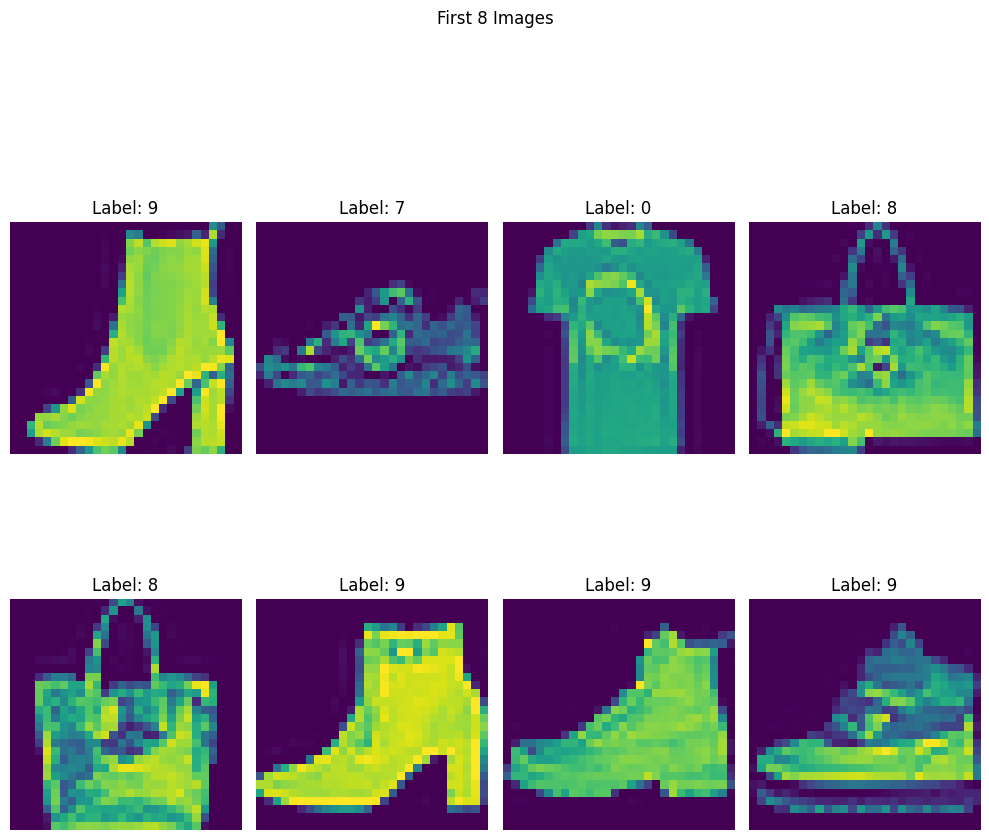

In [11]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(2,4,figsize=(10,10))
fig.suptitle("First 8 Images", fontsize=12)

# Now Plotting first 8 Images picking each from dataframe
for i, ax in enumerate(axes.flat):
  # One row of our dataframe has 1 label column and 784 (28x28) pixel columns
  # We only need pixel columns for an image to define
  # But for image to be shown imshow function need 2d matrix representation
  # of the image so we are reshaping the pixel column VALUES to respective
  # 2d shape which will be (28x28)
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)    # Displaying in Gray Scale
  ax.axis('off')    # Removing axis for cleaner look
  ax.set_title(f"Label: {df.iloc[i,0]}")  # Showing the labels

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [12]:
# For splitting our data we first have to define the feature MATRIX
# and the label VECTOR

# The Features for each sample are required so extracting every row iloc[:,__]
# The Features are our pixels COLUMNS which are present from index 1 onwards so iloc[___,1:]
X = df.iloc[:, 1:].values
# The Labels for each sample are required so extracting every row iloc[:,___]
# The Labels are present in first COLUMN so extracting index 0 iloc[___,0]
y = df.iloc[:, 0].values

In [13]:
# Splitting our data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Scaling the feautures manually
# As we have pixels in our data which can be from 0-255
# So dividing the maximum limit will put the data into resonable range
X_train = X_train/255.0
X_test = X_test/255.0

In [15]:
# Creating CustomDataset Class to Operate on our DataSet
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    # Features are made to datatype float32 to get precise operations
    # than that of integers and faster operations to that of float64
    self.features = torch.tensor(features, dtype=torch.float32)
    # We made the labels tensor to datatype long which is 64bit integer
    # because it is the specific requirement of a LOSS FUNCTION
    # As well as a basic standard
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    # For a specific index we want that indexed features and labels
    return self.features[index], self.labels[index]

In [16]:
# Now Creating Train DataSet
train_dataset = CustomDataset(X_train, y_train)

In [17]:
# Now Creating Test DataSet
test_dataset = CustomDataset(X_test, y_test)

In [18]:
# Defining Our Custom Model with Iterative Settings
# Model Architecture: Dynamically designed by Optuna
class MyNN(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()
    layers = []
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(neurons_per_layer, output_dim))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [22]:
# Defining Objective Function as Follows:
def objective(trial):
  # Hyperparameter values suggestions with search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, log=True)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  # Setting up dynamic loaders of data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # Model Initialization
  # Input Dimension come from our specific Problem which have 784 features
  # Output Dimension come from our distinct output numbers of problem which is 10
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # Defining loss and optimizers
  criterion = nn.CrossEntropyLoss()
  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Training Loop
  for epoch in range(epochs):
    for batch_features, batch_labels in train_loader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      outputs = model(batch_features)
      loss = criterion(outputs, batch_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Evaluation Loop
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total = total + batch_labels.shape[0]
      correct = correct + (predicted == batch_labels).sum().item()
  # Calculating the Accuracy
  accuracy = correct/total

  # Returning accuracy because we want optuna to increase accuracy of our system
  return accuracy

In [23]:
# Creating the Study to Optimize
study = optuna.create_study(direction='maximize')

[I 2026-02-07 16:45:26,055] A new study created in memory with name: no-name-6a759994-6a3e-4c7f-98a1-de06459e8901


In [24]:
# Starting the Optimization
study.optimize(objective, n_trials=10)

[I 2026-02-07 16:45:38,425] Trial 0 finished with value: 0.8266666666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 40, 'epochs': 40, 'learning_rate': 8.573435569341276e-05, 'dropout_rate': 0.1990139074073734, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 0.00045463124901250527}. Best is trial 0 with value: 0.8266666666666667.
[I 2026-02-07 16:46:05,796] Trial 1 finished with value: 0.8033333333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 56, 'epochs': 30, 'learning_rate': 0.0030969978284760584, 'dropout_rate': 0.4427557652240839, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 1.966719870117163e-05}. Best is trial 0 with value: 0.8266666666666667.
[I 2026-02-07 16:46:32,851] Trial 2 finished with value: 0.775 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48, 'epochs': 40, 'learning_rate': 1.1996665689584604e-05, 'dropout_rate': 0.48139402591084335, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_deca

In [25]:
# Checking the Best values and Parameters
print(f"Best Accuracy Value: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

Best Accuracy Value: 0.835
Best Parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 96, 'epochs': 40, 'learning_rate': 0.00016441861324173275, 'dropout_rate': 0.45687907181128984, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 2.258737792501133e-05}
